In [1]:
import math
import torch
import random
from torch import nn
from torch.autograd import Variable
from torch.distributions import Normal
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
%matplotlib inline
import os
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"

In [2]:
inputs = np.load('inputs_svgd-3.npy')
labels = np.load('labels_svgd-3.npy')
inputs.shape, labels.shape

((100, 160, 7), (100, 160))

### 利用RNN将传感器数据embedding

In [3]:
class RNNModel(nn.Module):
    """循环神经网络模型"""
    def __init__(self, rnn_layer, num_inputs, num_outputs, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.num_inputs, self.num_outputs = num_inputs, num_outputs
        self.num_hiddens = self.rnn.hidden_size
        # 如果RNN是双向的，‘num_direction'应该是2
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.num_outputs)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.num_outputs)
            
    def forward(self, inputs, state):
        X = torch.tensor(np.swapaxes(inputs,0,1), dtype=torch.float)
        Y, state = self.rnn(X, state)
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state
    
    def begin_state(self, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # 'nn.GRU' 以张量作为隐藏状态
            return torch.zeros((self.num_directions * self.rnn.num_layers,
                               batch_size, self.num_hiddens))
        else:
            # 'nn.LSTM' 以张量作为隐藏状态
            return (torch.zeros((
            self.num_directions * self.rnn.num_layers,
            batch_size, self.num_hiddens), device=device),
            torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens)))

### Prototypical networks

In [4]:
class Protonets(object):
    def __init__(self,num_tasks, num_steps, num_inputs, 
                 num_hiddens, num_outputs, batch_size, 
                 Ns, Nq, Nc):
        self.Ns, self.Nq, self.Nc = Ns, Nq, Nc
        self.num_tasks, self.num_hiddens, self.num_steps = num_tasks, num_hiddens, num_steps
        self.num_outputs, self.batch_size = num_outputs, batch_size
        
        rnn_layer = nn.RNN(num_inputs ,num_hiddens)
        self.model = RNNModel(rnn_layer, num_inputs, num_outputs)
        
    def eucli_distance(self, x, y):
        """计算两个tensor的欧氏距离"""
        return torch.sqrt(torch.sum((x-y)*(x-y)))

    def randomSample(self, D_set): 
        """从一个task的数据中随机取出support set和query set"""
        index_list = list(range(D_set.shape[0])) 
        random.shuffle(index_list)
        support_data_index = index_list[:self.Ns]
        query_data_index = index_list[self.Ns:self.Ns+self.Nq]

        support_set = []
        query_set = []

        for i in support_data_index:
            support_set.append(D_set[i])
        for i in query_data_index:
            query_set.append(D_set[i])

        return support_set,query_set

    def compute_center(self, support_set):
        """计算支持集对应的中心的点"""
        center = 0
        for i in range(self.Ns):
            if i==0:
                center = support_set[i]
            else:
                center += support_set[i]
        return center/self.Ns

    
    def loss(self, center1, query_set1, center2, query_set2):
        """计算损失"""
        loss = torch.zeros(2*self.Nq)
        for i in range(self.Nq):          
            #查询点与每个中心点逐个计算欧氏距离
            dis1 = self.eucli_distance(query_set1[i], center1)
            dis2 = self.eucli_distance(query_set1[i], center2)
            loss[i] = dis1 + torch.log(torch.exp(-dis1)+torch.exp(-dis2))
            
        for i in range(self.Nq):          
            #查询点与每个中心点逐个计算欧氏距离
            dis1 = self.eucli_distance(query_set2[i], center2)
            dis2 = self.eucli_distance(query_set2[i], center1)
            loss[i+Nq] = dis1 + torch.log(torch.exp(-dis1)+torch.exp(-dis2))
        
        return loss.sum()/(2*self.Nq)  
    
    def train(self, inputs, labels, lr):
        """模型训练"""
        task_index = list(range(self.num_tasks))
        random.shuffle(task_index)
        choss_task_indexs = task_index[:Nc]

        tmp_inputs = inputs[choss_task_indexs]
        tmp_labels = labels[choss_task_indexs]

        state = torch.zeros((1, self.batch_size, self.num_hiddens))
        outputs, state = self.model(tmp_inputs, state)
        outputs = outputs.reshape(self.num_steps, self.batch_size, 3)

        l = torch.zeros(self.Nc)
        for i in range(self.Nc):
            D_set = outputs[:,i]

            D1_set = D_set[np.where(tmp_labels[i]==0)]
            D2_set = D_set[np.where(tmp_labels[i]==1)]

            #从D1_set随机取支持集和查询集
            support_set1,query_set1 = self.randomSample(D1_set)
            center1 = self.compute_center(support_set1)

            support_set2,query_set2 = self.randomSample(D2_set)
            center2 = self.compute_center(support_set2)

            l[i] = self.loss(center1, query_set1, center2, query_set2)

        updater = optim.Adam(self.model.parameters(), lr)
        updater.zero_grad()
        l.mean().backward()
        updater.step()

        return l.mean().item()
    
    def accuracy(self, test_inputs, test_labels):
        """输出测试误差"""
        num_test_tasks = len(test_inputs)
        state = torch.zeros((1, num_test_tasks, self.num_hiddens))
        outputs, state = self.model(test_inputs, state)
        outputs = outputs.reshape(self.num_steps, num_test_tasks, 3)
        
        cnt = 0
        for i in range(num_test_tasks):
            D_set = outputs[:,i]

            D1_set = D_set[np.where(test_labels[i]==0)]
            D2_set = D_set[np.where(test_labels[i]==1)]

            #从D1_set随机取支持集和查询集
            support_set1,query_set1 = self.randomSample(D1_set)
            center1 = self.compute_center(support_set1)

            support_set2,query_set2 = self.randomSample(D2_set)
            center2 = self.compute_center(support_set2)
            
            for i in range(self.Nq):
                if self.eucli_distance(query_set1[i], center1) >= self.eucli_distance(query_set1[i], center2):
                    cnt += 1
                if self.eucli_distance(query_set2[i], center2) >= self.eucli_distance(query_set2[i], center1):
                    cnt += 1
        
        return (2*Nq*num_test_tasks-cnt)/(2*Nq*num_test_tasks)
    
    def record_protos(self, inputs, label):
        """记录历史任务的原型"""
        protos = []
        state = torch.zeros((1, self.num_tasks, self.num_hiddens))
        outputs, state = self.model(inputs, state)
        outputs = outputs.reshape(self.num_steps, self.num_tasks, 3)
        
        for i in range(self.num_tasks):
            D_set = outputs[:,i]

            D1_set = D_set[np.where(labels[i]==0)]
            D2_set = D_set[np.where(labels[i]==1)]

            #从D1_set随机取支持集和查询集
            support_set1,query_set1 = self.randomSample(D1_set)
            center1 = self.compute_center(support_set1)

            support_set2,query_set2 = self.randomSample(D2_set)
            center2 = self.compute_center(support_set2)
            
            protos.append([center1.detach().numpy(), center2.detach().numpy()])
            
        return protos

In [19]:
num_train = 40

num_tasks, num_steps, num_inputs = inputs[:num_train].shape
num_hiddens, num_outputs, batch_size = 20, 3, 5
Ns, Nq, Nc = 75, 5, 5

protonets = Protonets(num_tasks, num_steps, num_inputs, 
                     num_hiddens, num_outputs, batch_size, 
                    Ns, Nq, Nc)

# protonets = torch.load('net(40-5).pth')
print(protonets.accuracy(inputs[num_train:],labels[num_train:]))

0.9416666666666667


In [25]:
num_epochs = 300
for epoch in range(num_epochs):
    tmp_loss = protonets.train(inputs[:num_train], labels[:num_train], 0.001)
    if epoch%100 == 0:
        accuracy = protonets.accuracy(inputs[num_train:],labels[num_train:])
        print(f'epoch {epoch}, loss{tmp_loss:.4f}, accuracy{accuracy:.4f}')
print('finished training!')

epoch 0, loss0.0293, accuracy0.9483
epoch 100, loss0.0466, accuracy0.9583
epoch 200, loss0.1091, accuracy0.9567
finished training!


In [26]:
protos = protonets.record_protos(inputs[:num_train], labels[:num_train])
protos = np.array(protos)

state = torch.zeros((1, num_tasks, num_hiddens))
outputs, state = protonets.model(inputs[:num_train], state)
outputs = outputs.reshape(num_steps, num_tasks, 3)

protos.shape, outputs.shape

((40, 2, 3), torch.Size([160, 40, 3]))

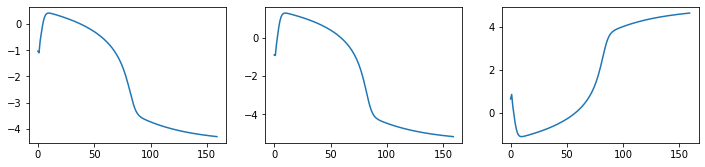

In [27]:
"""嵌入空间中特征分布"""
fig = plt.figure(figsize=(12,2.5))
for i in range(3):
    plt.subplot(1, 3, 1+i)
    plt.plot(outputs[:,2,i].detach().numpy())

In [35]:
torch.save(protonets,'net(.pth')

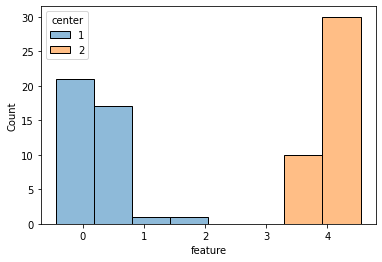

In [28]:
"""历史任务原型的分布"""
data = np.vstack((protos[:,0],protos[:,1]))
df_tmp = pd.DataFrame(data[:,2],columns=["feature"])
df_tmp['center'] = '1'
df_tmp.loc[num_train:,['center']] = '2'

sns.histplot(data=df_tmp,x="feature",hue="center")
plt.show()

### 查看在测试数据上的embedding效果

In [29]:
Psi = np.load('Psi_svgd-3.npy')

mu_i = np.load('test_mu_svgd-3.npy')
cov_i = np.load('test_cov_svgd-3.npy')

"""记录测试数据长度"""
df_test = pd.read_excel('test_data.xlsx')
num_test = df_test['Unit'].max()
length = []
for i in range(num_test):
    sensor_data = torch.tensor(df_test[df_test['Unit'] == i+1].iloc[:,2:].values, dtype = torch.float)  
    length.append(len(sensor_data))
    
mu_i.shape, cov_i.shape

((100, 21, 1), (100, 21, 21))

In [30]:
index, K = 5, 100
L = np.zeros((K, len(Psi), num_inputs))
gamma_samples = np.random.multivariate_normal(mu_i[index].flatten(), cov_i[index], size=K)
for k in range(K):
    L[k] = Psi @ gamma_samples[k].reshape(num_inputs,-1).T

state = torch.zeros((1, K, num_hiddens))
outputs, state = protonets.model(L, state)
outputs = outputs.reshape(len(Psi), K, 3)

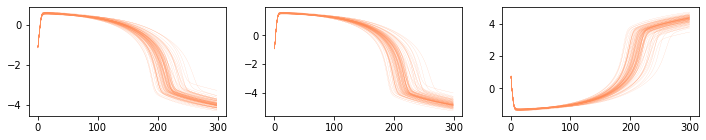

In [31]:
"""测试数据嵌入空间中特征分布"""
fig = plt.figure(figsize=(12,2))
for i in range(3):
    plt.subplot(1, 3, 1+i)
    for k in range(K):
        plt.plot(outputs[:300,k,i].detach().numpy(), color='#FF8D57', linewidth=0.1)
# plt.savefig('Embeddings.png',dpi=1000,bbox_inches ="tight")

## k-means聚类

In [32]:
index = 2
gamma_samples = np.random.multivariate_normal(mu_i[index].flatten(), cov_i[index], size=K)
L_list = np.zeros((K, len(Psi),num_inputs))
for k in range(K):
    L_list[k] = Psi @ gamma_samples[k].reshape(num_inputs,-1).T

state = torch.zeros((1, K, num_hiddens))
outputs, state = protonets.model(L_list, state)
outputs = outputs.reshape(len(Psi), K, 3)

p = np.zeros((K, Psi.shape[0]))
for k in range(K):
    L = outputs[:,k].detach().numpy()
    centroids, cluster = kmeans(L, 2)

    dis1 = np.sqrt(np.sum(((L - np.array(centroids[1]))**2),axis=1))
    dis2 = np.sqrt(np.sum(((L - np.array(centroids[0]))**2),axis=1))

    p[k] = (np.exp(-dis2)/(np.exp(-dis1)+(np.exp(-dis2)))) # 失效的概率

pp = np.sum(p,axis=0)/K
tmp_len = length[index]
p_T = (pp - pp[tmp_len])/(1 - pp[tmp_len])

print(np.where(p_T > 0.5)[0][0] - tmp_len)

61


In [33]:
K = 100
pred_RUL = np.zeros(num_test)
for i in range(num_test):
    gamma_samples = np.random.multivariate_normal(mu_i[i].flatten(), cov_i[i], size=K)
    L_list = np.zeros((K, len(Psi), num_inputs))
    for k in range(K):
        L_list[k] = Psi @ gamma_samples[k].reshape(num_inputs,-1).T
    
    state = torch.zeros((1, K, num_hiddens))
    outputs, state = protonets.model(L_list, state)
    outputs = outputs.reshape(len(Psi), K, 3)
    
    p = np.zeros((K, Psi.shape[0]))
    for k in range(K):
        L = outputs[:,k].detach().numpy()
        centroids, cluster = kmeans(L, 2)

        dis1 = np.sqrt(np.sum(((L - np.array(centroids[1]))**2),axis=1))
        dis2 = np.sqrt(np.sum(((L - np.array(centroids[0]))**2),axis=1))

        p[k] = (np.exp(-dis2)/(np.exp(-dis1)+(np.exp(-dis2))))
        
    pp = np.sum(p,axis=0)/K
    tmp_len = length[i]
    p_T = (pp - pp[tmp_len])/(1 - pp[tmp_len])
    pred_RUL[i] = np.where(p_T > 0.5)[0][0] - tmp_len

In [34]:
df_RUL = pd.read_csv('RUL_FD001.txt',names=['true_RUL'])
df_RUL['pred_RUL'] = pred_RUL
df_RUL['lifetime'] = df_RUL['true_RUL'] + length
df_RUL['error'] = np.abs(df_RUL['true_RUL']-df_RUL['pred_RUL'])/df_RUL['lifetime']
df_RUL['error'].mean()

0.06636913079254941

In [22]:
def RMSE(true_RUL, pred_RUL):
    d = true_RUL - pred_RUL
    return np.sqrt(np.power(d,2).mean())

In [23]:
RMSE(df_RUL['true_RUL'], df_RUL['pred_RUL'])

29.488133206427293

In [24]:
df_RUL['Unit'] = 1 + np.arange(num_test)
order = ['Unit','lifetime','true_RUL','pred_RUL','error']
df_RUL = df_RUL[order]
df_RUL.head()

,Unit,lifetime,true_RUL,pred_RUL,error
0,1,143,112,140.0,0.195804
1,2,147,98,116.0,0.122449
2,3,195,69,49.0,0.102564
3,4,188,82,63.0,0.101064
4,5,189,91,75.0,0.084656


In [52]:
df_RUL.to_excel('Result20.xlsx')

In [14]:
# 计算欧拉距离
def calcDis(dataSet, centroids, k):
    clalist=[]
    for data in dataSet:
        diff = np.tile(data, (k, 1)) - centroids  #相减   (np.tile(a,(2,1))就是把a先沿x轴复制1倍，即没有复制，仍然是 [0,1,2]。 再把结果沿y方向复制2倍得到array([[0,1,2],[0,1,2]]))
        squaredDiff = diff ** 2     #平方
        squaredDist = np.sum(squaredDiff, axis=1)   #和  (axis=1表示行)
        distance = squaredDist ** 0.5  #开根号
        clalist.append(distance) 
    clalist = np.array(clalist)  #返回一个每个点到质点的距离len(dateSet)*k的数组
    return clalist

# 计算质心
def classify(dataSet, centroids, k):
    # 计算样本到质心的距离
    clalist = calcDis(dataSet, centroids, k)
    # 分组并计算新的质心
    minDistIndices = np.argmin(clalist, axis=1)    #axis=1 表示求出每行的最小值的下标
    newCentroids = pd.DataFrame(dataSet).groupby(minDistIndices).mean() #DataFramte(dataSet)对DataSet分组，groupby(min)按照min进行统计分类，mean()对分类结果求均值
    newCentroids = newCentroids.values
 
    # 计算变化量
    changed = newCentroids - centroids
 
    return changed, newCentroids

# 使用k-means分类
def kmeans(dataSet, k):
    # 随机取质心
    centroids = [dataSet[0],dataSet[-1]]
    
    # 更新质心 直到变化量全为0
    changed, newCentroids = classify(dataSet, centroids, k)
    while np.any(changed != 0):
        changed, newCentroids = classify(dataSet, newCentroids, k)
 
    centroids = sorted(newCentroids.tolist())   #tolist()将矩阵转换成列表 sorted()排序
 
    # 根据质心计算每个集群
    cluster = []
    clalist = calcDis(dataSet, centroids, k) #调用欧拉距离
    minDistIndices = np.argmin(clalist, axis=1)  
    for i in range(k):
        cluster.append([])
    for i, j in enumerate(minDistIndices):   #enymerate()可同时遍历索引和遍历元素
        cluster[j].append(dataSet[i])
        
    return centroids, cluster

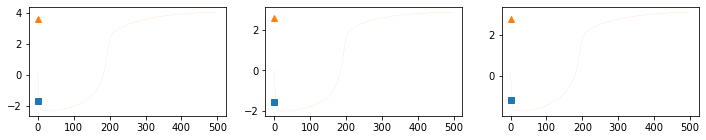

In [39]:
"""测试数据嵌入空间中特征分布"""
fig = plt.figure(figsize=(12,2))
for i in range(3):
    plt.subplot(1, 3, 1+i)
    plt.plot(outputs[:,0,i].detach().numpy(), color='#FF8D57', linewidth=1)
    plt.plot(centroids[0][i],'s')
    plt.plot(centroids[1][i],'^')

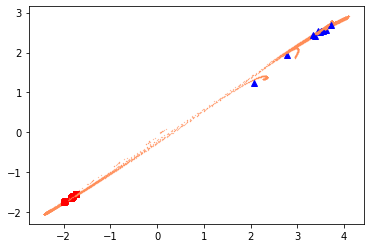

In [48]:
for k in range(10):
    tmp_data = outputs[:,k].detach().numpy()
    centroids, cluster = kmeans(tmp_data, 2)
    plt.plot(tmp_data[:,0],tmp_data[:,1],'.', color='#FF8D57', markersize=0.5)
    plt.plot(centroids[0][0],centroids[0][1],'rs')
    plt.plot(centroids[1][0],centroids[1][1],'b^')
    plt.plot()